# Investigating site variablity in embeddings extracted from different models using t-SNE visualizations.

In [377]:
# Load Dependencies

import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np
from omegaconf import OmegaConf, DictConfig
from umap import UMAP
from torch_geometric.nn import global_mean_pool



# Custom project imports (update to match your structure)
from data.loaders.abide_loader import get_abide_dataloaders

# Paths and Settings
CHECKPOINT_DIR = "/Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model"
OUTPUT_DIR = "embeddings"
MODEL_NAME = "dsam"  # or "dsam", "bnt", "braingnn"
BATCH_SIZE = 16
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")

In [378]:
# Load Model Checkpoint

def load_model_checkpoint(ckpt_path, cfg, dataloader=None):
    if cfg.models.name == "BrainNetworkTransformer":
        from models.bnt.bnt import BrainNetworkTransformer
        model = BrainNetworkTransformer(cfg)
    elif cfg.models.name == "BrainGNN":
        from models.braingnn.braingnn import Network as BrainGNN
        model = BrainGNN(cfg, dataloader)
    elif cfg.models.name == "SpatioTemporalModel":
        from models.dsam.dsam_original import SpatioTemporalModel
        model = SpatioTemporalModel(cfg, dataloader)
    else:
        raise ValueError(f"Unknown model type: {cfg.models.name}")
    
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model.to(device)

In [379]:
# Extract Embeddings from a Model

def extract_embeddings(model, dataloader, device, domain_id):
    model.to(device)
    model.eval()

    all_embeddings, all_labels, all_domains = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting Embeddings"):
            
            feats = None
            if cfg.models.name == "BrainGNN":
                
                batch = batch.to(device)
                num_nodes = cfg.dataset.num_nodes
                batch_size = batch.num_graphs
                identity = torch.eye(num_nodes, device=device)
                pseudo = identity.expand(batch_size, -1, -1).reshape(-1, num_nodes)
                batch.pseudo = pseudo

                feats = model.extract_features(batch)
            elif cfg.models.name == "SpatioTemporalModel":
           
                batch = batch.to(device)
                num_nodes = cfg.dataset.num_nodes
                batch_size = batch.num_graphs
                identity = torch.eye(num_nodes, device=device)
                pseudo = identity.unsqueeze(0).expand(batch_size, -1, -1).reshape(-1, num_nodes)
                batch.pseudo = pseudo

                feats = model.extract_features(batch)

            elif cfg.models.name == "BrainNetworkTransformer":
                batch = batch.to(device)
                node_feature = batch.x.view(batch.num_graphs, 200, -1)
                time_series = batch.time_series

                feats = model.extract_features(time_series, node_feature)

            if cfg.models.name == "SpatioTemporalModel":
                feats = global_mean_pool(feats, batch.batch)
            all_embeddings.append(feats.cpu())
            all_labels.append(batch.y.cpu())
            all_domains.append(torch.full_like(batch.y, fill_value=domain_id))

    return torch.cat(all_embeddings), torch.cat(all_labels), torch.cat(all_domains)

### Plot with t-SNE

In [380]:


def plot_tsne(embeddings, domains, title="t-SNE by Domain"):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.manifold import TSNE

    embeddings = np.array(embeddings)
    domains = np.array(domains)

    tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto")
    reduced = tsne.fit_transform(embeddings)

    # 🔐 Enforce shape match
    min_len = min(len(reduced), len(domains))
    reduced = reduced[:min_len]
    domains = domains[:min_len]

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=domains, palette="tab20", s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

###  UMAP Plot Function

In [381]:
def plot_umap(embeddings, domains, title="UMAP by Domain"):
    reducer = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine')
    reduced = reducer.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=domains, palette="tab20", s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

###  t-SNE by Diagnosis (ASD vs TD)

In [382]:
def plot_tsne_by_label(embeddings, labels, title="t-SNE by Diagnosis"):
   

    embeddings = np.asarray(embeddings)
    labels = pd.Series(labels).astype(str).str.strip()

    # Optional: map numeric to names
    labels = labels.replace({'0': 'TD', '1': 'ASD', 0: 'TD', 1: 'ASD'})
    labels = pd.Categorical(labels, categories=['TD', 'ASD'])

    tsne = TSNE(n_components=2, perplexity=30, init="pca",
                learning_rate="auto", random_state=0)
    reduced = tsne.fit_transform(embeddings)

    # Ensure matching lengths
    n = min(len(reduced), len(labels))
    reduced, labels = reduced[:n], labels[:n]

    palette = {"TD": "tab:blue", "ASD": "tab:orange"}

    fig, ax = plt.subplots(figsize=(10, 7))
    sns.scatterplot(
        x=reduced[:, 0], y=reduced[:, 1],
        hue=labels, hue_order=['TD','ASD'],
        palette=palette, s=60, alpha=0.8, ax=ax
    )

    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    # Use seaborn's legend (already color-synced)
    ax.legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


### Silhouette Score + Site Entropy

In [383]:
from scipy.stats import entropy
from collections import Counter

def compute_metrics(embeddings, domains):
    silhouette = silhouette_score(embeddings, domains)
    print(f"Silhouette Score (site clustering): {silhouette:.4f}")

    site_counts = Counter(domains)
    p = np.array([site_counts[k] for k in sorted(site_counts)])
    p = p / p.sum()
    ent = entropy(p, base=2)
    print(f"Site Entropy (bits): {ent:.4f}")
    return silhouette, ent

In [384]:
# Load Config and Run End-to-End

from hydra import initialize, compose

# Initialize Hydra config manually (for notebooks)
with initialize(version_base=None, config_path="config"):
    cfg = compose(config_name="config")
    print(OmegaConf.to_yaml(cfg))

os.makedirs(OUTPUT_DIR, exist_ok=True)
site_data, site_names = get_abide_dataloaders(cfg)

all_emb, all_lbl, all_dom = [], [], []

for site in site_names:
    domain_id = site_names.index(site)
    model_name = f"GRL-{MODEL_NAME}_{site}.pt"
    ckpt_path = os.path.join(CHECKPOINT_DIR, model_name)

    if not os.path.exists(ckpt_path):
        print(f"[SKIP] Missing checkpoint for {site}")
        continue

    print(f"[LOAD] Loading checkpoint for {site} from {ckpt_path}")
    dataloader = DataLoader(site_data[site], batch_size=BATCH_SIZE, shuffle=False)
    model = load_model_checkpoint(ckpt_path, cfg, dataloader)

    emb, lbl, dom = extract_embeddings(model, dataloader, device, domain_id)
    all_emb.append(emb)
    all_lbl.append(lbl)
    all_dom.append(dom)

    torch.save((emb, lbl, dom), os.path.join(OUTPUT_DIR, f"{model_name}_{site}.pt"))

repeat_time: 1
log_path: result
save_learnable_graph: false
local_host: false
wandb_entity: eggroup
project: Domain Adaptation - Tuned
dataset:
  name: abide
  batch_size: 16
  test_batch_size: 16
  val_batch_size: 16
  val_split: 0.1
  root: /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain
    Adaptation/data/abide/ABIDE_pcp/cpac/filt_noglobal
  stratified: true
  drop_last: true
  atlas: CC200
  connectivity: correlation
  use_h5: false
  phenotypic_file: /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain
    Adaptation/data/abide/ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv
  edge_threshold: 75
  include_ados: true
  use_1d: true
  dynamic: true
  num_nodes: 200
  time_points: 124
  site: null
models:
  name: SpatioTemporalModel
  alias: dsam
  activation: relu
  param_conv_strategy: tcn_entire
  channels_conv: 8
  early_stop_steps: 35
  final_mlp_layers: 1
  fold_num: 1
  n_clustered_communities: 7
  num_nodes: 200
  optim: Adam
  o

/var/folders/0f/kqcd07951gl12v32d1bck03r0000gn/T/ipykernel_15044/4263525844.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_locat

[LOAD] Loading checkpoint for CALTECH from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_CALTECH.pt


Extracting Embeddings: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


[LOAD] Loading checkpoint for CMU from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_CMU.pt


Extracting Embeddings: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


[LOAD] Loading checkpoint for KKI from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_KKI.pt


Extracting Embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


[LOAD] Loading checkpoint for LEUVEN_1 from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_LEUVEN_1.pt


Extracting Embeddings: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


[LOAD] Loading checkpoint for LEUVEN_2 from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_LEUVEN_2.pt


Extracting Embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


[LOAD] Loading checkpoint for MAX_MUN from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_MAX_MUN.pt


Extracting Embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


[LOAD] Loading checkpoint for NYU from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_NYU.pt


Extracting Embeddings: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


[LOAD] Loading checkpoint for OLIN from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_OLIN.pt


Extracting Embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


[LOAD] Loading checkpoint for PITT from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_PITT.pt


Extracting Embeddings: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


[LOAD] Loading checkpoint for SBL from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_SBL.pt


Extracting Embeddings: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


[LOAD] Loading checkpoint for SDSU from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_SDSU.pt


Extracting Embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


[LOAD] Loading checkpoint for STANFORD from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_STANFORD.pt


Extracting Embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


[LOAD] Loading checkpoint for TRINITY from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_TRINITY.pt


Extracting Embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


[LOAD] Loading checkpoint for UM_1 from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_UM_1.pt


Extracting Embeddings: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


[LOAD] Loading checkpoint for UM_2 from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_UM_2.pt


Extracting Embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


[LOAD] Loading checkpoint for USM from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_USM.pt


Extracting Embeddings: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


[LOAD] Loading checkpoint for YALE from /Users/jessessempijja/Documents/Adulting/Education/MSc/Dissertation/Domain Adaptation/checkpoints/best_model/GRL-dsam_YALE.pt


Extracting Embeddings: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


[DEBUG] all_emb shape: (875, 200)
[DEBUG] all_dom shape: (875,)


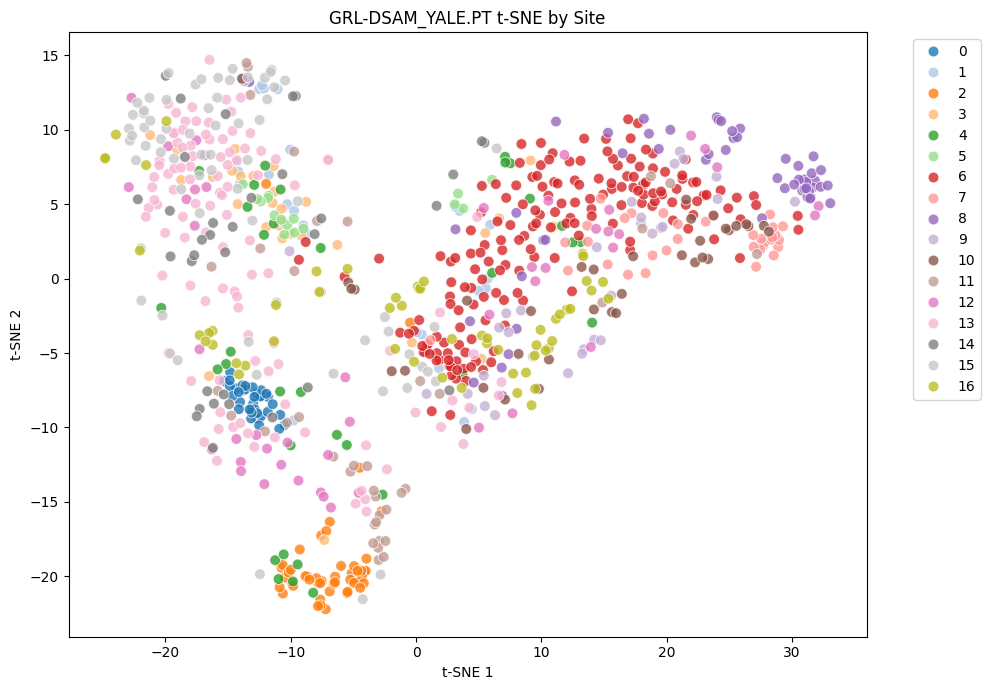

In [385]:
# Run t-SNE on All Extracted Embeddings

if len(all_emb) == 0:
    print("[ERROR] No embeddings found.")
else:
    all_emb = torch.cat(all_emb).cpu().numpy()
    all_dom = torch.cat(all_dom).cpu().numpy()
    print(f"[DEBUG] all_emb shape: {all_emb.shape}")
    print(f"[DEBUG] all_dom shape: {all_dom.shape}")
    # all_lbl = torch.cat(all_lbl).cpu().numpy()
    plot_tsne(all_emb, all_dom, title=f"{model_name.upper()} t-SNE by Site")

In [369]:
# os.environ["NUMBA_THREADING_LAYER"] = "workqueue"
# plot_umap(all_emb, all_dom, title="UMAP by Site")

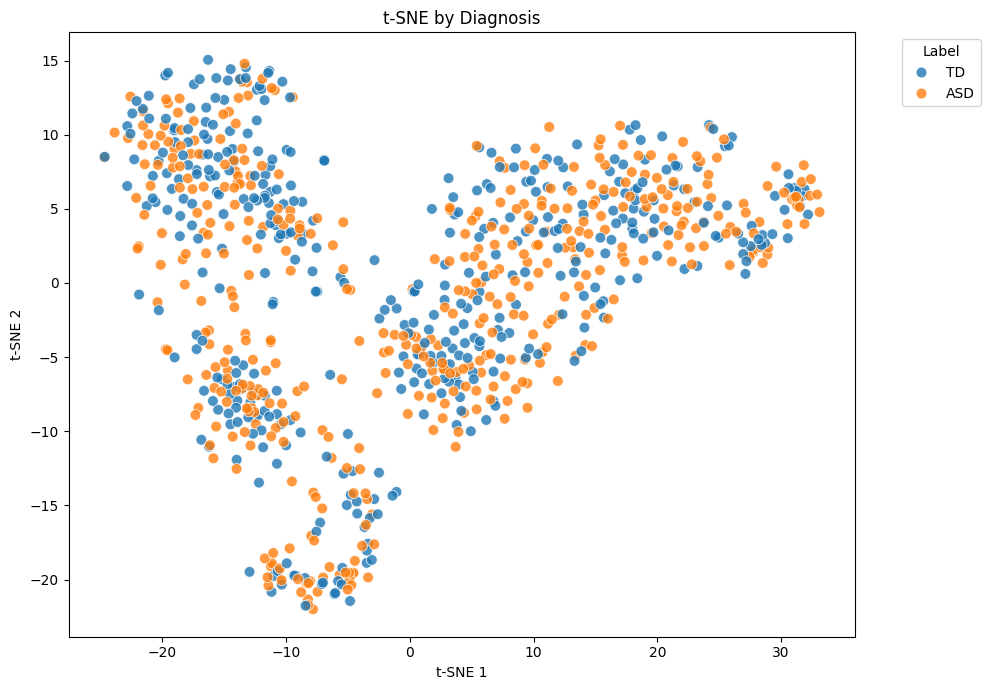

In [386]:
all_lbl = torch.cat(all_lbl).cpu().numpy()
plot_tsne_by_label(all_emb, all_lbl, title="t-SNE by Diagnosis")

In [387]:
compute_metrics(all_emb, all_dom)

Silhouette Score (site clustering): -0.1981
Site Entropy (bits): 3.8100


(-0.19805482029914856, np.float64(3.8100417372547413))